In [1]:
import numpy as np
import pcn              #using perceptron network
import kmeans           # and kmeans clustering algorithm

class rbf:
    

    def __init__(self,inputs,targets,nRBF,sigma=0,usekmeans=0,normalise=0):
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nRBF = nRBF
        self.usekmeans = usekmeans
        self.normalise = normalise
        
        if usekmeans:
            self.kmeansnet = kmeans.kmeans(self.nRBF,inputs)
            
        self.hidden = np.zeros((self.ndata,self.nRBF+1))
        
        if sigma==0:
            # Set width of Gaussians
            d = (inputs.max(axis=0)-inputs.min(axis=0)).max()
            self.sigma = d/np.sqrt(2*nRBF)  
        else:
            self.sigma = sigma
                
        self.perceptron = pcn.pcn(self.hidden[:,:-1],targets)
        
        # Initialise network
        self.weights1 = np.zeros((self.nin,self.nRBF))
        
    def rbftrain(self,inputs,targets,eta=0.25,niterations=100):
        if self.usekmeans==0:
            # Version 1: set RBFs to be datapoints
            indices = range(self.ndata)
            np.random.shuffle(indices)
            for i in range(self.nRBF):
                self.weights1[:,i] = inputs[indices[i],:]
        else:
            # Version 2: use k-means
            self.weights1 = np.transpose(self.kmeansnet.kmeanstrain(inputs))

        for i in range(self.nRBF):
            self.hidden[:,i] = np.exp(-np.sum((inputs - np.ones((1,self.nin))*self.weights1[:,i])**2,axis=1)/(2*self.sigma**2))
        if self.normalise:
            self.hidden[:,:-1] /= np.transpose(np.ones((1,np.shape(self.hidden)[0]))*self.hidden[:,:-1].sum(axis=1))
        
        # Call Perceptron without bias node (since it adds its own)
        self.perceptron.pcntrain(self.hidden[:,:-1],targets,eta,niterations)
        
    def rbffwd(self,inputs):

        hidden = np.zeros((np.shape(inputs)[0],self.nRBF+1))

        for i in range(self.nRBF):
            hidden[:,i] = np.exp(-np.sum((inputs - np.ones((1,self.nin))*self.weights1[:,i])**2,axis=1)/(2*self.sigma**2))

        if self.normalise:
            hidden[:,:-1] /= np.transpose(np.ones((1,np.shape(hidden)[0]))*hidden[:,:-1].sum(axis=1))
        
        # Add the bias
        hidden[:,-1] = -1
        outputs = self.perceptron.pcnfwd(hidden)
        return outputs
    
    def confmat(self,inputs,targets):
        """Confusion matrix"""

        outputs = self.rbffwd(inputs)
        nClasses = np.shape(targets)[1]

        if nClasses==1:
            nClasses = 2
            outputs = np.where(outputs>0,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            for j in range(nClasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        output = cm
        print("Confusion matrix is:")
        print(cm)
        print("Percentage Correct: ", np.trace(cm) / np.sum(cm) * 100)
        return output

In [2]:
iris = np.loadtxt('banknote.csv',delimiter=',')
iris[:,:4] = iris[:,:4]-iris[:,:4].mean(axis=0)
imax = np.concatenate((iris.max(axis=0)*np.ones((1,5)),iris.min(axis=0)*np.ones((1,5))),axis=0).max(axis=0)
iris[:,:4] = iris[:,:4]/imax[:4]
print (iris[0:5,:])

[[ 0.49880026  0.61144219 -0.25438505  0.20451374  0.        ]
 [ 0.64342405  0.56622605 -0.23328978 -0.07427406  0.        ]
 [ 0.53704115 -0.4135054   0.03185603  0.3565094   0.        ]
 [ 0.47298296  0.68911749 -0.32721727 -0.6598847   0.        ]
 [-0.01635021 -0.57824013  0.19202762  0.05571211  0.        ]]


In [3]:
iris.shape

(1372, 5)

In [4]:
target = np.zeros((np.shape(iris)[0], 2))
indices = np.where(iris[:,4]==0) 
target[indices,0] = 1
indices = np.where(iris[:,4]==1)
target[indices,1] = 1
'''
indices = np.where(iris[:,9]==2)
target[indices,2] = 1
indices = np.where(iris[:,9]==3) 
target[indices,0] = 1
indices = np.where(iris[:,9]==4)
target[indices,1] = 1
indices = np.where(iris[:,9]==5)
target[indices,2] = 1
indices = np.where(iris[:,9]==5)
target[indices,2] = 1
'''


'\nindices = np.where(iris[:,9]==2)\ntarget[indices,2] = 1\nindices = np.where(iris[:,9]==3) \ntarget[indices,0] = 1\nindices = np.where(iris[:,9]==4)\ntarget[indices,1] = 1\nindices = np.where(iris[:,9]==5)\ntarget[indices,2] = 1\nindices = np.where(iris[:,9]==5)\ntarget[indices,2] = 1\n'

In [5]:
order = np.arange(np.shape(iris)[0])
np.random.shuffle(order)
iris = iris[order,:]
target = target[order,:]

In [6]:
train = iris[::2,0:4]
traint = target[::2]
valid = iris[1::4,0:4]
validt = target[1::4]
test = iris[3::4,0:4]
testt = target[3::4]


In [7]:
print (train.max(axis=0), train.min(axis=0))

[1. 1. 1. 1.] [-1.16973236 -1.42307569 -0.40284444 -1.83464881]


In [8]:
net = rbf(train,traint,5,1,1)

net.rbftrain(train,traint,0.25,5000)
print("Train data:-")
net.confmat(train,traint)
print("Test data:-")
cm = net.confmat(test,testt)

Train data:-
Confusion matrix is:
[[363. 110.]
 [  5. 208.]]
Percentage Correct:  83.23615160349854
Test data:-
Confusion matrix is:
[[186.  53.]
 [  5.  99.]]
Percentage Correct:  83.09037900874635


In [9]:
cm

array([[186.,  53.],
       [  5.,  99.]])

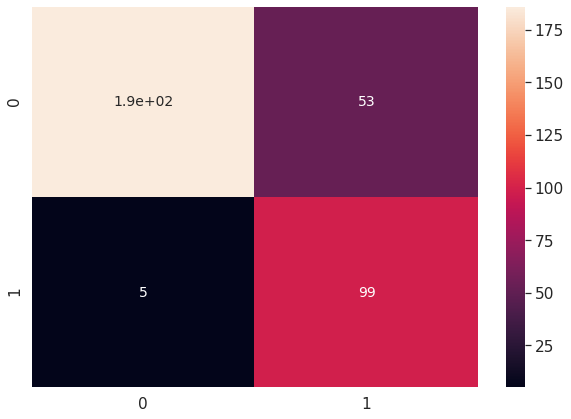

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = np.array(cm)
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14})  # font size
plt.show()

In [11]:
from sklearn.metrics import classification_report
targets=testt
inputs = test
nClasses = np.shape(targets)[1]
outputs = net.rbffwd(inputs)
if nClasses==1:
    nClasses = 2
    outputs = np.where(outputs>0,1,0)
else:
    # 1-of-N encoding
    outputs = np.argmax(outputs,1)
    targets = np.argmax(targets,1)


print(classification_report(targets, outputs))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       191
           1       0.95      0.65      0.77       152

    accuracy                           0.83       343
   macro avg       0.87      0.81      0.82       343
weighted avg       0.86      0.83      0.82       343



In [12]:
import MLP as mlp 
net =mlp.mlp(train,traint,20,outtype='logistic')
net.earlystopping(train,traint,valid,validt,0.1)
cm=net.confmat(test,testt)

1
Iteration:  0  Error:  171.34742384282475
Iteration:  100  Error:  342.9999986814771
Iteration:  200  Error:  342.99999867933263
Iteration:  300  Error:  342.99999867680503
Iteration:  400  Error:  342.9999986742679
Iteration:  500  Error:  342.9999986717212
Iteration:  600  Error:  342.99999866916494
Iteration:  700  Error:  342.9999986665989
Iteration:  800  Error:  342.99999866402334
Iteration:  900  Error:  342.99999866143787
Iteration:  1000  Error:  342.9999986588426
Iteration:  1100  Error:  342.9999986562375
Iteration:  1200  Error:  342.99999865362247
Iteration:  1300  Error:  342.99999865099744
Iteration:  1400  Error:  342.99999864836235
Iteration:  1500  Error:  342.99999864571714
Iteration:  1600  Error:  342.9999986430619
Iteration:  1700  Error:  342.99999864039626
Iteration:  1800  Error:  342.99999863772047
Iteration:  1900  Error:  342.9999986350342
Iteration:  2000  Error:  342.9999986323377
Iteration:  2100  Error:  342.9999986296306
Iteration:  2200  Error:  342.

In [13]:
from sklearn.metrics import classification_report
targets=testt
inputs=np.concatenate((test,-np.ones((np.shape(test)[0],1))),axis=1)
nclasses=np.shape(targets)[1]
output=net.mlpfwd(inputs)
if nclasses==1:
    nclasses=2
    output=np.where(output>0.5,1,0)
else:
    output=np.argmax(output,1)
    targets=np.argmax(targets,1)
   
print(classification_report(targets,output))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       191
           1       0.00      0.00      0.00       152

    accuracy                           0.56       343
   macro avg       0.28      0.50      0.36       343
weighted avg       0.31      0.56      0.40       343



/home/mona/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
